### Imports

In [121]:
import pandas as pd
import numpy as np
import subprocess
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

### load raw data

In [122]:
# load data
braker = pd.read_csv('./braker.gff3_red', sep='\t')

### process into chunks and send off to slurm

### content of get_rho_chunk.py

```python
# input
import pandas as pd
import argparse
import numpy as np

# def function
def cli_parser():
    '''
    parses command line input
   
    '''
    parser_main = argparse.ArgumentParser(prog='run_rho_chunk.py')
    parser_main.add_argument("--input",
                             help="path to the folder that contains the vcf files that should be merged",
                             required = True)

    args = parser_main.parse_args()
    return args

def get_weighted_mean_rho(ss_data, row):
  if ss_data.shape[0]==0:
    return 'no_overlap_bin'
  else:
    rho_fracs= []
    overlaps = []
    for i, b in ss_data.iterrows():
      bin_start = (b.Pos_kb_start*1e3)
      bin_end = (b.Pos_kb_end*1e3)
      gene_start = row.Start_pos
      gene_end = row.End_pos
      if bin_start < gene_start:
        if bin_end > gene_end:
          #print('all of the gene is in the bin, return rho')
          return b.Mean_rho
        else:
          # overlap is bin_end - gene_start
          overlap = bin_end - gene_start
          rho_frac = b.Mean_rho*overlap
      else:
        if bin_end > gene_end:
          overlap = gene_end - bin_start
          rho_frac = b.Mean_rho*overlap
        else:
          overlap = bin_end - bin_start
          rho_frac = b.Mean_rho*overlap
      rho_fracs.append(rho_frac)
      overlaps.append(overlap)
    return sum(rho_fracs)/sum(overlaps)


# run stuff

# load data
args =cli_parser()
chunk = pd.read_csv(args.input, sep=',')
data = pd.read_csv('./concat_Mbel_excl5scaff_rmind_hardfilt_exhet_biall_dp_qfilt_mac2_maxmiss06_rmfilt_sedmiss_phimp.vcf_LDhat_bpen1_statres_100N_red.txt', sep='\t')


weighted_mean_rho = []
for index,row in chunk.iterrows():
  ss_data = data.loc[data.Scaffold==row.Scaffold].loc[(data.Pos_kb_start*1e3)<row.End_pos].loc[(data.Pos_kb_end*1e3)>row.Start_pos]
  rho = get_weighted_mean_rho(row=row, ss_data=ss_data)
  weighted_mean_rho.append(",".join([str(j) for j in row])+','+str(rho))
  if index%1e2 == 0:
    print(",".join([str(j) for j in row])+','+str(rho))
    print(index)
    
# write output

outfile = args.input.rstrip("gff3_chunk")+".rho"
with open(outfile, "wt") as handle:
    handle.write('\n'.join(weighted_mean_rho))
```


In [123]:
#split into chunks and write them
chunk_n = 200
braker_split = np.array_split(braker, chunk_n)

In [124]:
def create_and_submit_sbatch(batch, chunk):
    name="rho_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 2:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_rho_chunk.py --input {chunk}".format(chunk=chunk)]
    with open("braker_chunks2/"+name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", "braker_chunks2/"+name])
    subprocess.call(["sbatch", "braker_chunks2/"+name])

In [125]:
for i, k in enumerate(braker_split):
    chunkname = "./braker_chunks2/braker_chunk_{chunk_i}.gff3_chunk".format(chunk_i=i)
    k.to_csv(chunkname)
    create_and_submit_sbatch(batch=i, chunk=chunkname)

Submitted batch job 39327679
Submitted batch job 39327680
Submitted batch job 39327681
Submitted batch job 39327682
Submitted batch job 39327683
Submitted batch job 39327684
Submitted batch job 39327685
Submitted batch job 39327686
Submitted batch job 39327687
Submitted batch job 39327688
Submitted batch job 39327689
Submitted batch job 39327690
Submitted batch job 39327691
Submitted batch job 39327692
Submitted batch job 39327693
Submitted batch job 39327694
Submitted batch job 39327695
Submitted batch job 39327696
Submitted batch job 39327697
Submitted batch job 39327698
Submitted batch job 39327699
Submitted batch job 39327700
Submitted batch job 39327701
Submitted batch job 39327702
Submitted batch job 39327703
Submitted batch job 39327704
Submitted batch job 39327705
Submitted batch job 39327706
Submitted batch job 39327707
Submitted batch job 39327708
Submitted batch job 39327709
Submitted batch job 39327710
Submitted batch job 39327711
Submitted batch job 39327712
Submitted batc

### collect results

In [135]:
rho_chunks =  [ i for i in os.listdir("./braker_chunks2") if i.endswith(".rho")]

In [136]:
len(rho_chunks) # all chunks are there

200

In [152]:
rho_chunks_df = pd.concat([pd.read_csv(os.path.join("./braker_chunks2",i), header=None) for i in rho_chunks])

In [153]:
rho_chunks_df = rho_chunks_df.sort_values([1,3,4])

In [154]:
rho_chunks_df.columns = ["old_index"]+list(braker.columns)+['weighted_mean_rho']

### how many genes do not have an associated rho-value?

In [141]:
Counter(rho_chunks_df.weighted_mean_rho).most_common(5)

[('no_overlap_bin', 37204),
 ('1.31625', 1458),
 ('0.00682', 1154),
 ('0.02511', 1064),
 ('28.8939', 865)]

In [145]:
rho_chunks_df.shape

(827909, 7)

In [143]:
(37204/823770)*100

4.51630916396567

#### roughly 4.5%

### plotting

In [157]:
rho_chunks_df.weighted_mean_rho

270     0.66661
271     0.66661
272     0.66661
273     0.66661
274     0.66661
         ...   
2833    0.08865
2834    0.08865
2835    0.08865
2836    0.08865
2837    0.08865
Name: weighted_mean_rho, Length: 827909, dtype: object

In [158]:
# drop missing values
rho_chunks_df=rho_chunks_df.replace('no_overlap_bin', np.nan)

In [160]:
rho_chunks_df.weighted_mean_rho = rho_chunks_df.weighted_mean_rho.astype(float)

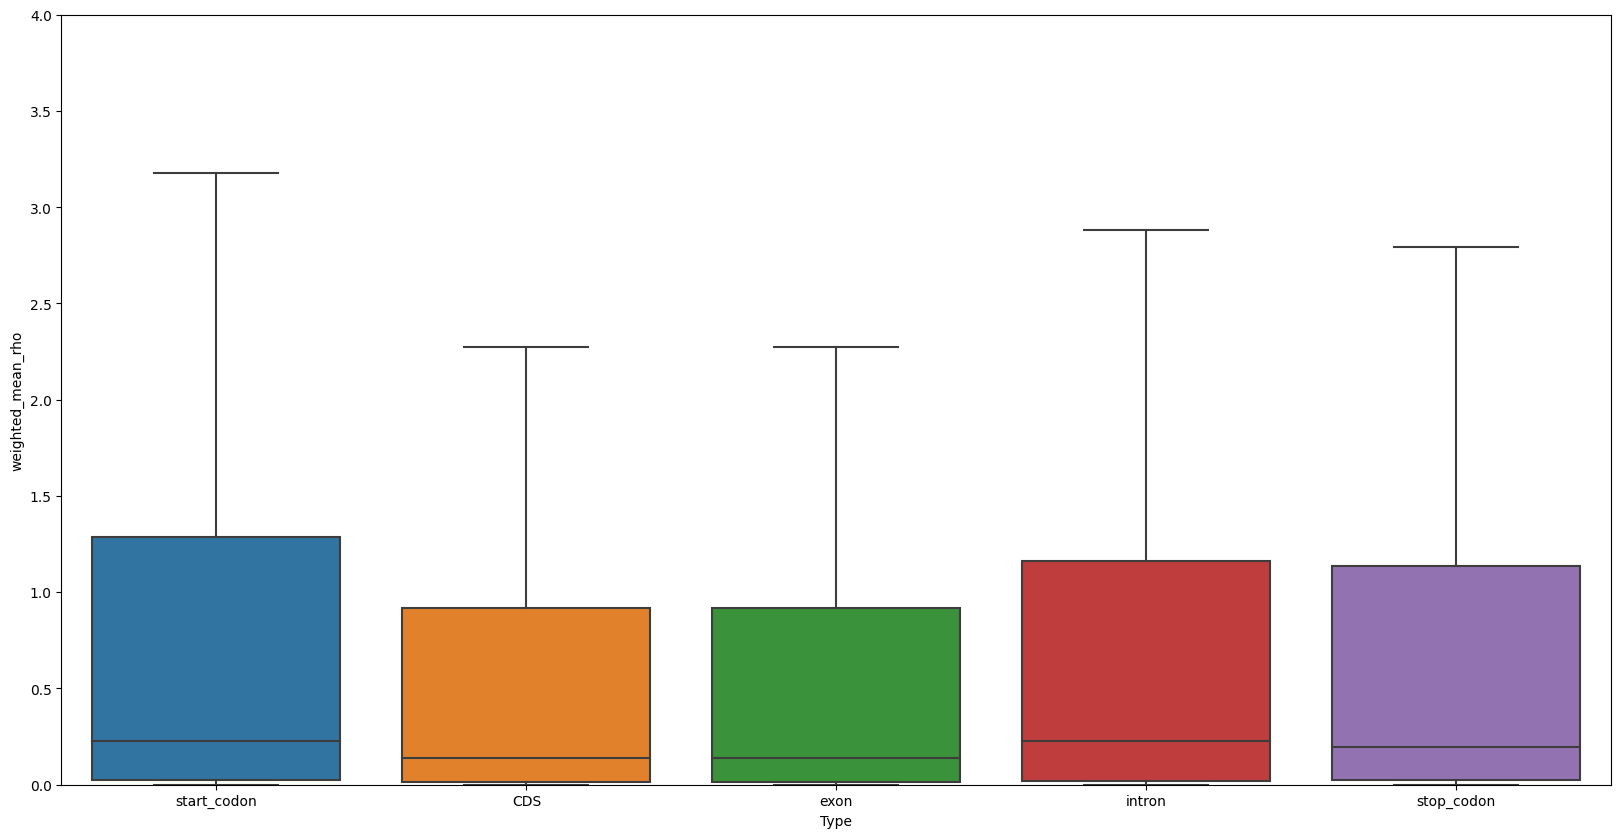

In [175]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(20,10))
sns.boxplot(x=rho_chunks_df["Type"], y=rho_chunks_df["weighted_mean_rho"],fliersize=0, ax=ax )
plt.ylim(0,4)
plt.show()                       

249.47952

In [177]:
gb_rho = rho_chunks_df.groupby("Type")

In [179]:
gb_rho.weighted_mean_rho.mean()

Type
CDS            3.508157
exon           3.508157
intron         3.498127
start_codon    3.836048
stop_codon     3.761558
Name: weighted_mean_rho, dtype: float64

In [181]:
gb_rho.weighted_mean_rho.std()

Type
CDS            10.836931
exon           10.836931
intron         10.512917
start_codon    11.772698
stop_codon     12.016225
Name: weighted_mean_rho, dtype: float64

In [183]:
gb_rho.weighted_mean_rho.median()

Type
CDS            0.13708
exon           0.13708
intron         0.22722
start_codon    0.22746
stop_codon     0.19728
Name: weighted_mean_rho, dtype: float64